In [2]:
import numpy as np 
import cv2
import time
# import read_position_data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from flax import linen as nn
import skimage
import jax
import pickle
from flax.training.train_state import TrainState
import optax


In [5]:
class Autoencoder(nn.Module):
    @nn.remat
    @nn.compact
    def __call__(self, x):
        # Encoder
        x = nn.Conv(16, (3, 3), strides=(1, 1), padding="SAME")(x)
        x = nn.relu(x)

        x = nn.Conv(32, (3, 3), strides=(1, 1), padding="SAME")(x)
        x = nn.relu(x)


        x = nn.ConvTranspose(32, (3, 3), strides=(1, 1), padding="SAME")(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(16, (3, 3), strides=(1, 1), padding="SAME")(x)
        x = nn.relu(x)

        x = nn.Conv(1, (3, 3), strides=(1, 1), padding="SAME")(x)

        return nn.sigmoid(x)  # Output activation
model = Autoencoder()
dummy_input = jax.random.normal(jax.random.PRNGKey(0), (1, 216, 216, 1))
params = model.init(jax.random.PRNGKey(0), dummy_input)

model_state = TrainState.create(
        apply_fn=model.apply, params=params, tx=optax.adam(0.001)
    )
# Load pretrained model
with open("model_3400.pkl", "rb") as f:
        model_params= pickle.load(f)

model_state = model_state.replace(
    params=model_params
)


2025-03-12 14:31:39.560671: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(506, 506)


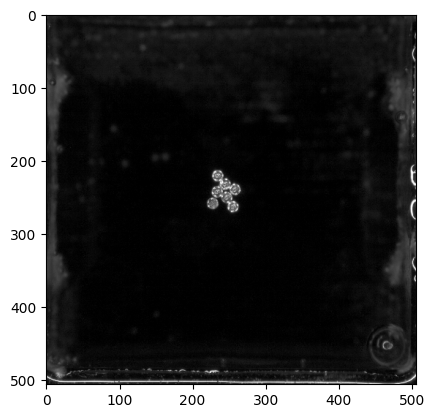

In [23]:

input_data = plt.imread("../images/latest_camera_image.png")
input_data = input_data[:,:,0]
print(input_data.shape)
# input_data = cv2.resize(input_data, (216,216))

mean = np.mean(input_data)
std = np.std(input_data)
input_data = (input_data - mean) / std
plt.imshow(input_data, cmap='gray')



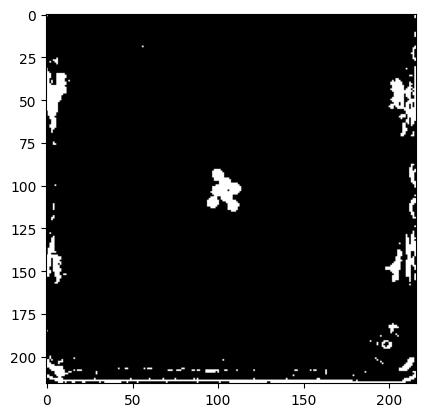

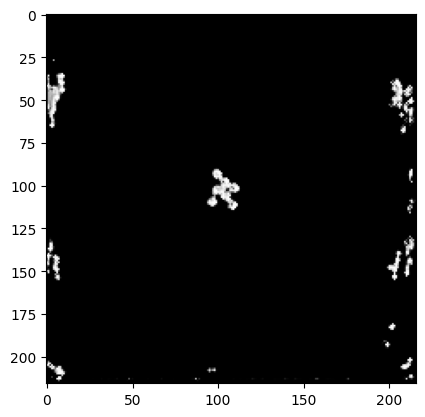

In [8]:
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
# image = cv2.erode(input_data, kernel, iterations=1)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

# image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=3)
# # image = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
# plt.imshow(thresholded_image, cmap='gray')
thresholded_image = input_data > 1.9
plt.imshow(thresholded_image.reshape(216,216, 1), cmap='gray')
plt.show()
cleaned_image = model.apply(model_state.params, thresholded_image.reshape(1, 216, 216, 1))
plt.imshow(cleaned_image[0,:,:,0], cmap='gray')

0
0.02041459083557129


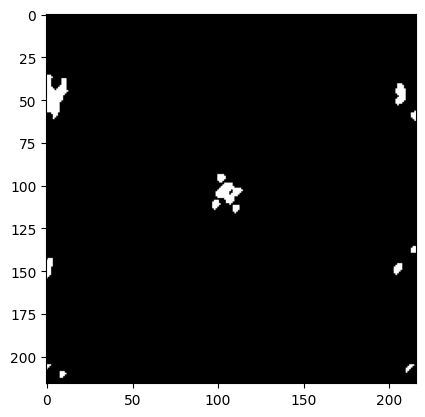

In [22]:
start = time.time()
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
image = cv2.erode(input_data, kernel, iterations=1)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
# image = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
thresholded_image = image > 1.9
plt.imshow(thresholded_image, cmap='gray')
image = np.array(thresholded_image*255, dtype=np.uint8) 
params = cv2.SimpleBlobDetector_Params()
params.filterByColor = True
params.blobColor = 255
# params.filterByCircularity = False
# params.minCircularity = 0.1
# params.maxCircularity = 1
# params.filterByConvexity = False
# params.minConvexity = 0.01
# params.maxConvexity = 1
params.filterByArea = True
params.maxArea = 50
params.minArea = 25
# params.filterByCircularity = True
# params.minCircularity = 0.9
# params.maxCircularity = 1
params.filterByConvexity = False  # Allow irregular shapes
params.filterByInertia = False  # Allow elongated shapes
params.filterByCircularity = True
params.minCircularity = 0.8
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(image.astype(np.uint8))
print(len(keypoints))
print(time.time()-start)
image_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image_with_keypoints, cmap="gray")
# plt.savefig("blob_detection.png")
# plt.show()

